In [1]:
## This notebook is for comparing the Transmitter off and RFI measurements...

workingdir='/home/tyndall/newburghlab-drone'
from dronehacks.GBO_Corr_Class import *
from dronehacks.Drone_Class import *

In [2]:
## Key, Position, Channel, Polarization, Pointing Variable Assignment:
## RECEIVER INFORMATION is needed to initialize the geometric environments: ##
## Must include some 'key' strings for labelling/identifying receivers: [Pranav's Conventions]
Array_Keys=["Dish_0","Dish_7","Dish_2","Dish_3","Dish_4","Dish_5","Dish_6","Dish_8"]
## Specify Coordinate Origin: #810m about MSL
GBO_HIRAX_DISH_0=pygeodesy.ellipsoidalNvector.LatLon(38.429280, -79.844990, 810).to3llh()
## Must Specify Coordinates and Pointings of receivers in Local Cartesian in an array of shape: n_receivers x 3 ##
Array_Coords=np.array([[0.0, 0.0, 0.0], # "Dish_0" \
                       [-24.215395745765452, -12.605737141316427, 0.0], # "Dish_7" \
                       [-8.403824760877617, 16.143597163843634, 0.0], # "Dish_2" \
                       [-8.071798581921817, -4.2019123804388085, 0.0], # "Dish_3" \
                       [-12.273710962360624, 3.869886201483008, 0.0], # "Dish_4" \
                       [-16.475623342799434, 11.941684783404824, 0.0], # "Dish_5" \
                       [-20.345509544282443, -0.33202617895580033, 0.0], # "Dish_6" \
                       [-28.41730812620426, -4.53393855939461, 0.0]]) # "Dish_8" \
## If pointings are defined by vectors in Local Coordinates (E,N,U) use:
Array_Pointings=np.array([[0,0,1], # +Z (up) in LC \
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1]])
## If pointings are defined by angles from zenith, use:
Array_Pointings=np.array([RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),  # e.g. 1 deg of yaw and roll \
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0])])
## Define Array Polarizations (2 per dish) in Local Cartesian E,N,U:
Array_Pols=np.array([[[1,0,0],[0,1,0]], # E,N \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]]])

## 8 DISH PLOTTING:
GBO8_chmap=np.array([0,1,3,2,4,5,7,6,9,8,10,11,12,13,14,15])
GBO8_automap=np.array([0,  16,  45,  31,  58,  70,  91,  81, 108, 100, 115, 121, 126, 130, 133, 135])

In [3]:
## Time array isn't valid because of interpolation bug, since drone data starts before telescope data...
## Fix interpolation axes of ds_CORR and ds_drone to solve this issue...?

from scipy.signal import square
from scipy.stats import pearsonr

def Interp_Switch(x,t_full,switch_full):
    return np.interp(x,t_full,switch_full)

def Pulsed_Data_Waveform(total_duration,period,duty_cycle_on):
    ## Outputs should be an array of timedeltas and an array of switch voltages (1s and 0s)
    ## Let's make the time resolution of these arrays milliseconds (10^-3 sec):
    t_steps_ms=int(datetime.timedelta(seconds=total_duration).total_seconds()*1e3)+1 #n_steps
    t_arr_s=np.linspace(0,total_duration,t_steps_ms)
    ## Use the square function from scipy.signal to produce the 1s and 0s:
    switch_signal_arr=0.5*square((2*np.pi/(period*1e-6))*t_arr_s,duty_cycle_on/period)+0.5
    ## Create a timedelta array for interpolation purposes so we can interpolate the square wave later:
    t_arr_datetime=np.array([datetime.timedelta(seconds=timeval) for timeval in t_arr_s])
    return t_arr_s,t_arr_datetime,switch_signal_arr

class CONCAT:
    def __init__(self,CORRDATCLASS,DRONEDATCLASS):
        print('Initializing CONCAT CLASS using:')
        print(" --> "+CORRDATCLASS.Data_Directory)
        print(" --> "+DRONEDATCLASS.fn)
        ## Identify Filenames used in CONCAT Class:
        self.fn_corr=CORRDATCLASS.filenames
        self.fn_drone=DRONEDATCLASS.fn  
        ## Time dimensions of all arrays must be concat with receiver data. Time index is therefore defined wrt telescope data.
        self.t_index=CORRDATCLASS.t_index
        self.t_arr_datetime=CORRDATCLASS.t_arr_datetime
        self.f_arr=CORRDATCLASS.freq
        self.V=CORRDATCLASS.V_full
        self.n_channels=CORRDATCLASS.n_channels
        self.chmap=CORRDATCLASS.chmap
        ## Define lb and ub t_index corresponding to drone data start/stop times:
        drone_t_min=DRONEDATCLASS.t_arr_datetime[0]
        drone_t_max=DRONEDATCLASS.t_arr_datetime[-1]
        CORR_t_ind_lb=bisect.bisect_right(self.t_arr_datetime, drone_t_min)
        CORR_t_ind_ub=bisect.bisect_left(self.t_arr_datetime, drone_t_max)
        ## Define interpolation time vectors for drone and corr data:
        tsepoch=datetime.datetime.utcfromtimestamp(0).replace(tzinfo=pytz.UTC)
        ds_CORR=np.array([(np.datetime64(ts).astype(datetime.datetime).replace(tzinfo=pytz.UTC)-tsepoch).total_seconds() for ts in self.t_arr_datetime[CORR_t_ind_lb:CORR_t_ind_ub]])
        ds_drone=np.array([(np.datetime64(ts).astype(datetime.datetime).replace(tzinfo=pytz.UTC)-tsepoch).total_seconds() for ts in DRONEDATCLASS.t_arr_datetime])
        #ds_CORR=[(self.t_arr_datetime[n]-self.t_arr_datetime[CORR_t_ind_lb]).total_seconds() for n in self.t_index[CORR_t_ind_lb:CORR_t_ind_ub]]
        #ds_drone=[(DRONEDATCLASS.t_arr_datetime[m]-drone_t_min).total_seconds() for m in DRONEDATCLASS.t_index]
        print("Interpolating drone coordinates for each correlator timestamp:")
        print("  --> correlator timestamp axis contains {} elements".format(len(ds_CORR)))
        print("  --> drone timestamp axis contains {} elements".format(len(ds_drone)))
        ## Create useful drone coordinate arrays which we must interp, NAN non valued elements:
        self.drone_llh_interp=np.NAN*np.ones((self.t_arr_datetime.shape[0],3))
        self.drone_xyz_LC_interp=np.NAN*np.ones((self.t_arr_datetime.shape[0],3))
        self.drone_rpt_interp=np.NAN*np.ones((self.t_arr_datetime.shape[0],3))
        self.drone_yaw_interp=np.NAN*np.ones(self.t_arr_datetime.shape[0])
        self.drone_rpt_r_per_dish_interp=np.NAN*np.ones((DRONEDATCLASS.rpt_r_per_dish.shape[0],self.t_arr_datetime.shape[0],3))
        self.drone_rpt_t_per_dish_interp=np.NAN*np.ones((DRONEDATCLASS.rpt_r_per_dish.shape[0],self.t_arr_datetime.shape[0],3))
        ## Interp Drone variables:
        for i in [0,1,2]:
            self.drone_llh_interp[CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.coords_llh[:,i])
            self.drone_xyz_LC_interp[CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.coords_xyz_LC[:,i])
            self.drone_rpt_interp[CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.coords_rpt[:,i])
            for j in range(DRONEDATCLASS.rpt_r_per_dish.shape[0]):            
                self.drone_rpt_r_per_dish_interp[j,CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.rpt_r_per_dish[j,:,i])
                self.drone_rpt_t_per_dish_interp[j,CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.rpt_t_per_dish[j,:,i])
        self.drone_yaw_interp[CORR_t_ind_lb:CORR_t_ind_ub]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.yaw[:])

    def Extract_Source_Pulses(self,Period=0.4e6,Dutycycle=0.2e6,t_bounds=[0,-1],f_ind=[900],half_int_period=0.021):
        ## Create Switch Signal
        self.pulse_period=Period
        self.pulse_dutycycle=Dutycycle
        concat_duration=int(np.ceil((self.t_arr_datetime[-1]-self.t_arr_datetime[0]).total_seconds()))
        time_s,time_dt,switch=Pulsed_Data_Waveform(total_duration=concat_duration,period=self.pulse_period,duty_cycle_on=self.pulse_dutycycle)
        ## Create t_offset range (1 period) and Pearson_r vars:
        t_offset_dist=np.linspace(-1.0*self.pulse_period*1e-6,0.0,1000)
        Pr_arr=np.zeros((self.n_channels,t_offset_dist.shape[0]))
        Pr_max_ind_per_channel=np.zeros(self.n_channels)
        Pr_max_t_0_per_channel=np.zeros(self.n_channels)
        ## Define bounds for plotting later on:
        cdtlb,cdtub=t_bounds
        ## Loop over channels to find/plot a time offset solution with some clever fitting:
        fig1,ax1=subplots(nrows=1,ncols=1,figsize=(16,4))
        for i in range(self.n_channels):
            ## If we use a mean subtracted data cut we can find where power exceeds zero to find signal
            minsubdata=self.V[:,f_ind,i]-np.nanmin(self.V[:,f_ind,i])
            normminsubdata=minsubdata/np.nanmax(minsubdata)
            t_full=np.array([(m-self.t_arr_datetime[0]).total_seconds() for m in self.t_arr_datetime[:]])
            ## Loop over all time offsets in t_offset_dist to find maximum correlation between squarewave and data:
            for j,t_offset in enumerate(t_offset_dist):
                shiftedswitch=Interp_Switch(t_full,time_s+t_offset,switch)
                try:
                    Pr_arr[i,j]=pearsonr(normminsubdata.flatten(),shiftedswitch.flatten())[0]
                except ValueError:
                    Pr_arr[i,j]=np.NAN
            ax1.plot(t_offset_dist,Pr_arr[i,:],'.')
            try:
                maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]
                ax1.plot(t_offset_dist[maxPrind],Pr_arr[i,maxPrind],'ro')
                Pr_max_ind_per_channel[i]=maxPrind
                Pr_max_t_0_per_channel[i]=t_offset_dist[maxPrind]
            except IndexError:
                Pr_max_ind_per_channel[i]=np.NAN
                Pr_max_t_0_per_channel[i]=np.NAN
        t_offset_global=np.nanmedian(Pr_max_t_0_per_channel)+half_int_period # 1/2 integration period
        ax1.axvline(t_offset_global,label="t_offset with half-int-period")
        ax1.axvline(t_offset_global-half_int_period,label="t_offset without half-int-period")
        ax1.legend(loc=1)
        print("Maximum Pearson_R Correlations:") 
        print("  --> t_indices = {}".format(Pr_max_ind_per_channel))
        print("  --> t_offsets = {}".format(Pr_max_t_0_per_channel))
        print("Selecting global time offset:")
        print("  --> global_t_offset = {:.10f}".format(t_offset_global))
        ## Interpolate the switching function with the concat timestamps:
        t_for_interp_out=np.array([(m-self.t_arr_datetime[0]).total_seconds() for m in self.t_arr_datetime])
        t_for_interp_in=np.array([m.total_seconds() for m in time_dt])
        switch_interp_f=np.interp(t_for_interp_out,t_for_interp_in+t_offset_global,switch)
        ## Once we have our time offset, we must extract indices where the source is on/off/rising:
        print("Finding relevant pulsing indices and checking for overlaps:")
        self.inds_span=np.union1d(list(set(np.where(np.diff(np.sign(switch_interp_f-0.5)))[0])),\
                                  np.intersect1d(np.where(1.0>switch_interp_f),np.where(switch_interp_f>0.0))).tolist()
        self.inds_on=list(set(np.where(switch_interp_f==1.0)[0])-set(self.inds_span))
        self.inds_off=list(set(np.where(switch_interp_f==0.0)[0])-set(self.inds_span))
        ## Each of these lists of indices should also have no overlap. Let's print to see:
        print("  --> on/off ind intersection:",np.intersect1d(self.inds_on,self.inds_off))
        print("  --> on/span ind intersection:",np.intersect1d(self.inds_on,self.inds_span))
        print("  --> off/span ind intersection:",np.intersect1d(self.inds_off,self.inds_span))
        ## Let's plot the on/off/rising index groups:
        fig3=figure(figsize=(16,int(4*self.n_channels/2)))
        for i in range(self.n_channels):
            ax=fig3.add_subplot(int(self.n_channels/2),2,i+1)   
            ax.semilogy(self.t_arr_datetime[:],self.V[:,f_ind,i],'k.',label='all')
            ax.semilogy(self.t_arr_datetime[self.inds_on],self.V[self.inds_on,f_ind,i],'.',label='on')
            ax.semilogy(self.t_arr_datetime[self.inds_off],self.V[self.inds_off,f_ind,i],'.',label='off')   
            ax.semilogy(self.t_arr_datetime[self.inds_span],self.V[self.inds_span,f_ind,i],'x',label='span')
            ax.semilogy(self.t_arr_datetime[:],(np.nanmax(self.V[self.inds_on,f_ind,i])*switch_interp_f)+np.nanmin(self.V[self.inds_on,f_ind,i]),'--',alpha=0.1,label='switch, t_offset={:.2f}'.format(t_offset_dist[maxPrind]))
            ax.set_ylabel("Log Power Received [$ADU^2$]")
            ax.set_xlabel("Datetime")
            ax.set_title("Channel {}".format(self.chmap[i]))
            ax.legend(loc=2)
            ax.set_xlim(self.t_arr_datetime[cdtlb],self.t_arr_datetime[cdtub])
        tight_layout()
        
    def Perform_Background_Subtraction(self):
        ## BACKGROUND SUBTRACTED SPECTRA: ##
        self.V_bg_construct=np.zeros(self.V.shape)
        self.V_meansub=np.zeros(self.V.shape)
        ## Loop over all indices and construct the V_bg array:
        for k,ind in enumerate(self.t_index):
            ## If ind is an off spectra, use this off spectra for the background:
            if k in self.inds_off:
                #print(k,"poo")
                self.V_bg_construct[k,:,:]=self.V[k,:,:]
            ## If ind is an on spectra, create an off spectra by averaging the before/after off spectra:
            elif k in np.union1d(self.inds_on,self.inds_span):
                t_window=np.intersect1d(np.arange(k-10,k+10),self.inds_off)
                #print(k,t_window)
                self.V_bg_construct[k,:,:]=np.nanmean(self.V[t_window,:,:],axis=0)
        self.V_meansub=self.V-self.V_bg_construct
        
    def Perform_Background_Subtraction_old(self):
        ## BACKGROUND SUBTRACTED SPECTRA: ##
            # we want to mean-subtract the on spectra by subtracting off the average before and after spectra
            # if we have N "on" spectra, we need to select N+1 "off" spectra for the before/after arrays
            # let's construct this using the inds_on, inds_off, and inds_span spectra:
        ## Find the first and last off pulse, and select the span indices between these indices (in inds_span):
        span_lb=np.where(self.inds_span>self.inds_off[0])[0][0]
        span_ub=np.where(self.inds_span<self.inds_off[-1])[0][-1]
        bin_indices=np.append(np.append(self.inds_off[0],self.inds_span[span_lb:span_ub+1]),self.inds_off[-1])
        ## inititalize and loop to create lists of on/off pulse indices for averaging:
        self.meansub_on_inds=[]
        self.meansub_off_inds=[]
        ## Now loop over the span indices we've created above to extract groups of on and off indices (in t_index):
        for j,ind in enumerate(bin_indices[:-1]):
            if int(bin_indices[j]+1) in self.inds_on:
                indcut=np.intersect1d(self.t_index[bin_indices[j]:bin_indices[j+1]],self.inds_on).tolist()
                if len(indcut)>0:
                    self.meansub_on_inds.append(indcut)
            elif int(bin_indices[j]+1) in self.inds_off:
                indcut=np.intersect1d(self.t_index[bin_indices[j]:bin_indices[j+1]],self.inds_off).tolist()
                if len(indcut)>0:
                    self.meansub_off_inds.append(indcut)            
        ## initialize averaged arrays for t with dimension n_on and V with dimensions n_on,f,t 
        n_on_pulses=len(self.meansub_on_inds)
        self.pulse_t_ind=np.zeros(n_on_pulses).astype(int)
        self.pulse_V_on=np.zeros((n_on_pulses,len(self.f_arr),self.n_channels))
        self.pulse_V_bg=np.zeros((n_on_pulses,len(self.f_arr),self.n_channels))
        self.pulse_V_meansub=np.zeros((n_on_pulses,len(self.f_arr),self.n_channels))
        ## Loop over the indices (in inds_span) we've created and populate the t and V_meansub arrays:
        for k,indlist in enumerate(self.meansub_on_inds):
            meanspec_off_L=np.nanmean(self.V[self.meansub_off_inds[k],:,:],axis=0)
            meanspec_off_R=np.nanmean(self.V[self.meansub_off_inds[k+1],:,:],axis=0)
            meanbgs=0.5*(meanspec_off_L+meanspec_off_R)
            self.pulse_V_on[k]=np.nanmean(self.V[self.meansub_on_inds[k],:,:],axis=0)
            self.pulse_V_bg[k]=meanbgs
            self.pulse_V_meansub[k]=np.nanmean(self.V[self.meansub_on_inds[k],:,:],axis=0)-meanbgs
            self.pulse_t_ind[k]=indlist[0]

    def Plot_Beammap_LC(self,t_bounds=[0,-1],coord_args="LC",pulse_args=None,f_bounds=[300,340],cbounds=[],dotsize=40):
        fig1=figure(figsize=(16,int(8*self.n_channels/2)))
        for i in range(int(self.n_channels/2)):
            ## No pulse_args: all data
            if pulse_args==None:
                t_cut=np.arange(t_bounds[0],t_bounds[1])
                pt_colors_1=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                pt_colors_2=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
            ## pulse_args="on" only source on
            elif pulse_args is "on":
                t_cut=np.intersect1d(np.arange(t_bounds[0],t_bounds[1]),self.inds_on).tolist()
                pt_colors_1=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                pt_colors_2=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
            ## pulse_args="off" only source off
            elif pulse_args is "off":
                t_cut=np.intersect1d(np.arange(t_bounds[0],t_bounds[1]),self.inds_off).tolist()
                pt_colors_1=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                pt_colors_2=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
            ## pulse_args="meanspec_xx" selects the pulse-averaged data:
            elif "meanspec" in pulse_args:
                t_cut=np.intersect1d(np.arange(t_bounds[0],t_bounds[1]),self.pulse_t_ind).tolist()
                pulsebds=[np.where(t_cut[0]==self.pulse_t_ind)[0][0],np.where(t_cut[-1]==self.pulse_t_ind)[0][0]+1]
                t_cut_ms=np.arange(pulsebds[0],pulsebds[1])
                ## pulse_args="meanspec_on" pulse-averaged on spectra
                if pulse_args is "meanspec_on":
                    pt_colors_1=np.nanmean(self.pulse_V_on[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                    pt_colors_2=np.nanmean(self.pulse_V_on[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
                ## pulse_args="meanspec_bg" pulse-averaged off spectra (background spectra)
                if pulse_args is "meanspec_bg":
                    pt_colors_1=np.nanmean(self.pulse_V_bg[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                    pt_colors_2=np.nanmean(self.pulse_V_bg[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
                ## pulse_args="meanspec_meansub" pulse-averaged background subtracted on pulses (on-off)
                if pulse_args is "meanspec_meansub":
                    pt_colors_1=np.nanmean(self.pulse_V_meansub[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                    pt_colors_2=np.nanmean(self.pulse_V_meansub[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
            ## Create axes and assign assign x,y points from drone using coords of choice:
            if coord_args is "LC":
                ax1=fig1.add_subplot(int(self.n_channels/2),2,int(2*i)+1)
                ax2=fig1.add_subplot(int(self.n_channels/2),2,int(2*i)+2)
                x=self.drone_xyz_LC_interp[t_cut,0]
                y=self.drone_xyz_LC_interp[t_cut,1]
                im1=ax1.scatter(x,y,s=dotsize,c=pt_colors_1,cmap='gnuplot2',norm=LogNorm())
                im2=ax2.scatter(x,y,s=dotsize,c=pt_colors_2,cmap='gnuplot2',norm=LogNorm())
            elif coord_args is "Pol":
                ax1=fig1.add_subplot(int(self.n_channels/2),2,int(2*i)+1,projection="polar")
                ax2=fig1.add_subplot(int(self.n_channels/2),2,int(2*i)+2,projection="polar")
                x=self.drone_rpt_r_per_dish_interp[i,t_cut,1]
                y=180.0/np.pi*self.drone_rpt_r_per_dish_interp[i,t_cut,2]
                im1=ax1.scatter(x,y,s=dotsize,c=pt_colors_1,cmap='gnuplot2',norm=LogNorm())
                im2=ax2.scatter(x,y,s=dotsize,c=pt_colors_2,cmap='gnuplot2',norm=LogNorm())
            ## set color limits to fix the L,R plots to same colorscale:
            images=[im1,im2]
            for im in images:
                mincl=np.nanmin([im1.get_clim()[0],im2.get_clim()[0]])
                maxcl=np.nanmax([im1.get_clim()[1],im2.get_clim()[1]])
                if len(cbounds)==2:
                    im.set_clim(cbounds[0],cbounds[1])
                else:
                    im.set_clim(mincl,maxcl)
            for j,ax in enumerate([ax1,ax2]):
                ax.set_facecolor('k')
                ax.set_title('GBO-HIRAX Array Channel {} Beammap'.format(self.chmap[int(2*i)+j]))
                if coord_args is "LC":
                    ax.set_xlabel('X Position $[m]$')
                    ax.set_ylabel('Y Position $[m]$')
                    divider=make_axes_locatable(ax)
                    cax=divider.append_axes("right", size="3%", pad=0.05)
                    cbar=fig1.colorbar(images[j],cax=cax)
                    cbar.set_label('Power [$ADU^2$]')
                if coord_args is "Pol":
                    cbar=fig1.colorbar(images[j],ax=ax,aspect=40)
                    cbar.set_label('Power [$ADU^2$]')
        tight_layout()
        

In [4]:
## Thursday 100m Pulsed Grid Flight w/ 16 Channels / 8 Dishes:

## Initialize correlator data class and pull auto correlations:
gaindir='/hirax/GBO_Data/TONE_ACQ/digital_gains/20210826T195003Z_yale_drone_yale_digitalgain/'
datadir='/hirax/GBO_Data/Emilys_Rsync/processed/20210826T195003Z_yale_drone/corr/20210826T195014Z/'

main_beam_corr=Corr_Data(n_channels=16,\
                              chmap=GBO8_chmap,\
                              Data_Directory=datadir,\
                              Working_Directory=workingdir,\
                                Data_File_Index=range(95), # last 2 files are worthless (power outage) \
                              Gain_Directory=gaindir)

Initializing Correlator Class using:
 --> /hirax/GBO_Data/Emilys_Rsync/processed/20210826T195003Z_yale_drone/corr/20210826T195014Z/
 --> Arrays initialized with shape (95, 256, 1023, 16)
Assigning array values by reading in data files:
 --> Loading File: 0094_processed/0096_processed

In [5]:
## Read Drone Data: 
drone_directory='/hirax/all_drone_data/datcon_csv/'
ndishes=8
main_beam_drone=Drone_Data(dronedir=drone_directory,\
                                FLYTAG='FLY536.csv',\
                                Origin_llh=GBO_HIRAX_DISH_0,\
                                Origin_key='Hirax_Dish_0',\
                                dkeys=Array_Keys[:ndishes],\
                                dcoords=Array_Coords[:ndishes],\
                                dpointings=Array_Pointings[:ndishes],\
                                dpols=Array_Pols[:ndishes])

Initializing drone data via datcon_csv routine: FLY536.csv
Interpolating time starting at 2021-08-26T19:50:28Z
generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
generating dish and receiver line of sight coordinates.


In [6]:
## Initialize CONCAT class and interpolate drone coords:
mainbeamconcat=CONCAT(CORRDATCLASS=main_beam_corr,DRONEDATCLASS=main_beam_drone)

Initializing CONCAT CLASS using:
 --> /hirax/GBO_Data/Emilys_Rsync/processed/20210826T195003Z_yale_drone/corr/20210826T195014Z/
 --> FLY536.csv


/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 23980 elements
  --> drone timestamp axis contains 12842 elements


/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide
/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: All-NaN slice encountered


Maximum Pearson_R Correlations:
  --> t_indices = [466. 480. 501. 473. 465. 480. 122. 479. 466. 480. 464. 481. 481.  nan
 501. 473.]
  --> t_offsets = [-0.21341341 -0.20780781 -0.1993994  -0.21061061 -0.21381381 -0.20780781
 -0.35115115 -0.20820821 -0.21341341 -0.20780781 -0.21421421 -0.20740741
 -0.20740741         nan -0.1993994  -0.21061061]
Selecting global time offset:
  --> global_t_offset = -0.1872082082
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


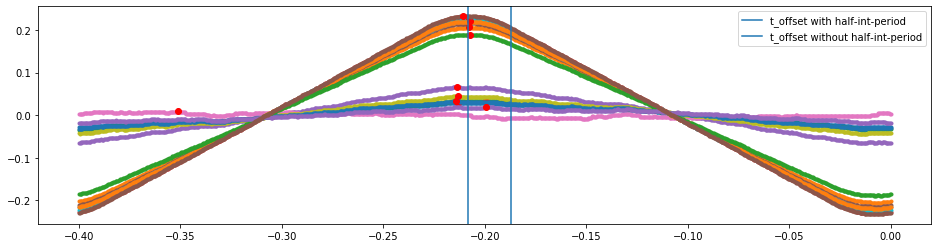

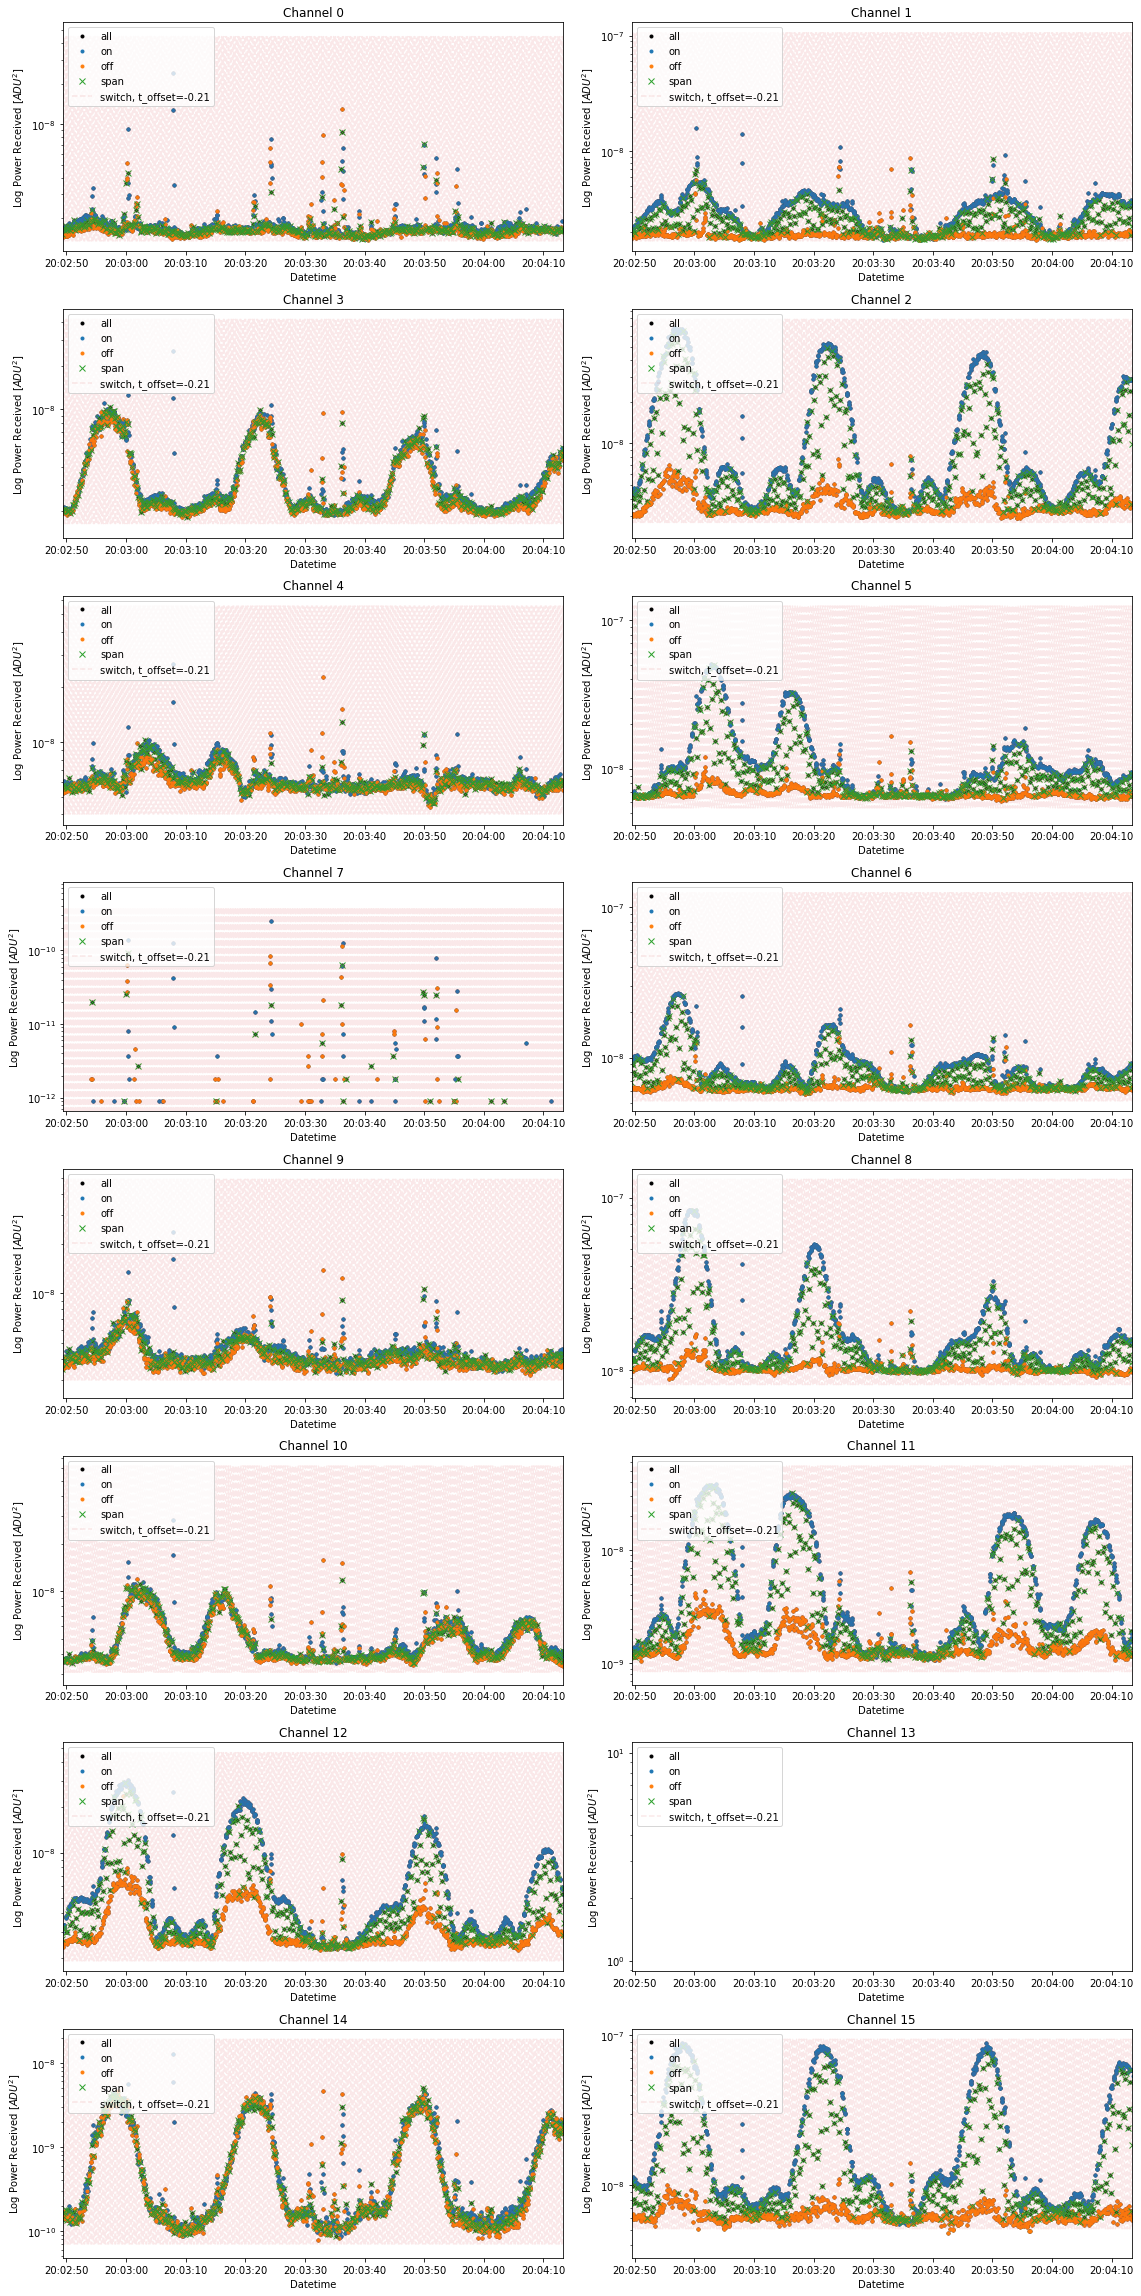

In [13]:
## Find the pulsed source signal: (comment out if source was broadcast continuously)
mainbeamconcat.Extract_Source_Pulses(Period=0.4e6,\
                                       Dutycycle=0.2e6,\
                                       t_bounds=[18000,20000],\
                                       f_ind=[905],\
                                       half_int_period=0.021)

In [14]:
mainbeamconcat.Perform_Background_Subtraction()

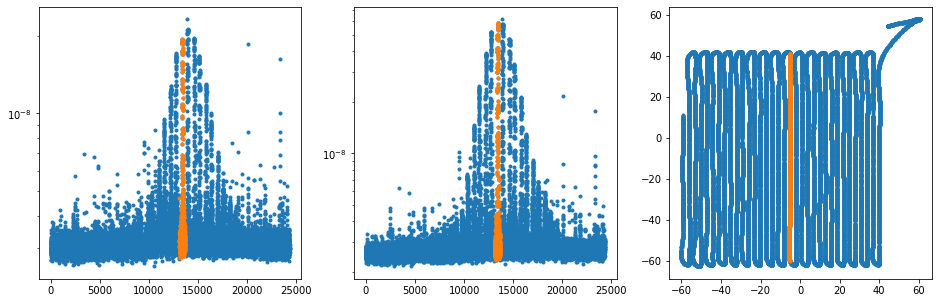

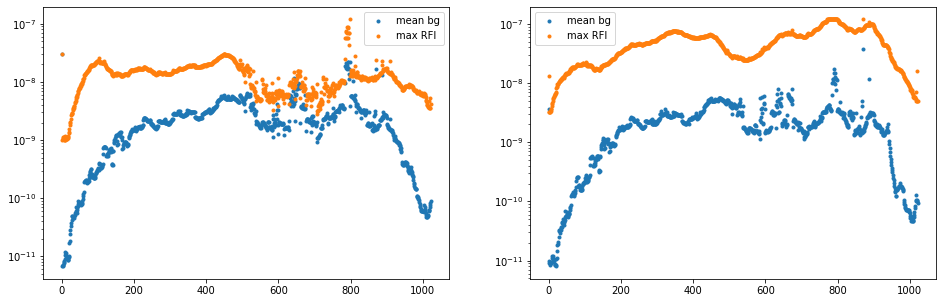

In [64]:
fig1,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
tlb,tub=[0,-1]
#tlb,tub=[4125,24000]
ax1.semilogy(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.V[tlb:tub,400,0],'.')
ax2.semilogy(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.V[tlb:tub,400,1],'.')
ax3.plot(mainbeamconcat.drone_xyz_LC_interp[tlb:tub,0],mainbeamconcat.drone_xyz_LC_interp[tlb:tub,1],'.')
tlb,tub=[13100,13650]
ax1.semilogy(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.V[tlb:tub,400,0],'.')
ax2.semilogy(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.V[tlb:tub,400,1],'.')
ax3.plot(mainbeamconcat.drone_xyz_LC_interp[tlb:tub,0],mainbeamconcat.drone_xyz_LC_interp[tlb:tub,1],'.')

fig2,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,5))
for i,ax in enumerate([ax1,ax2]):
    ax.semilogy(np.nanmean(mainbeamconcat.V[0:2000,:,i],axis=0),'.',label='mean bg')
    ax.semilogy(np.nanmax(mainbeamconcat.V[13100:13650,:,i],axis=0),'.',label='max RFI')
    ax.legend()


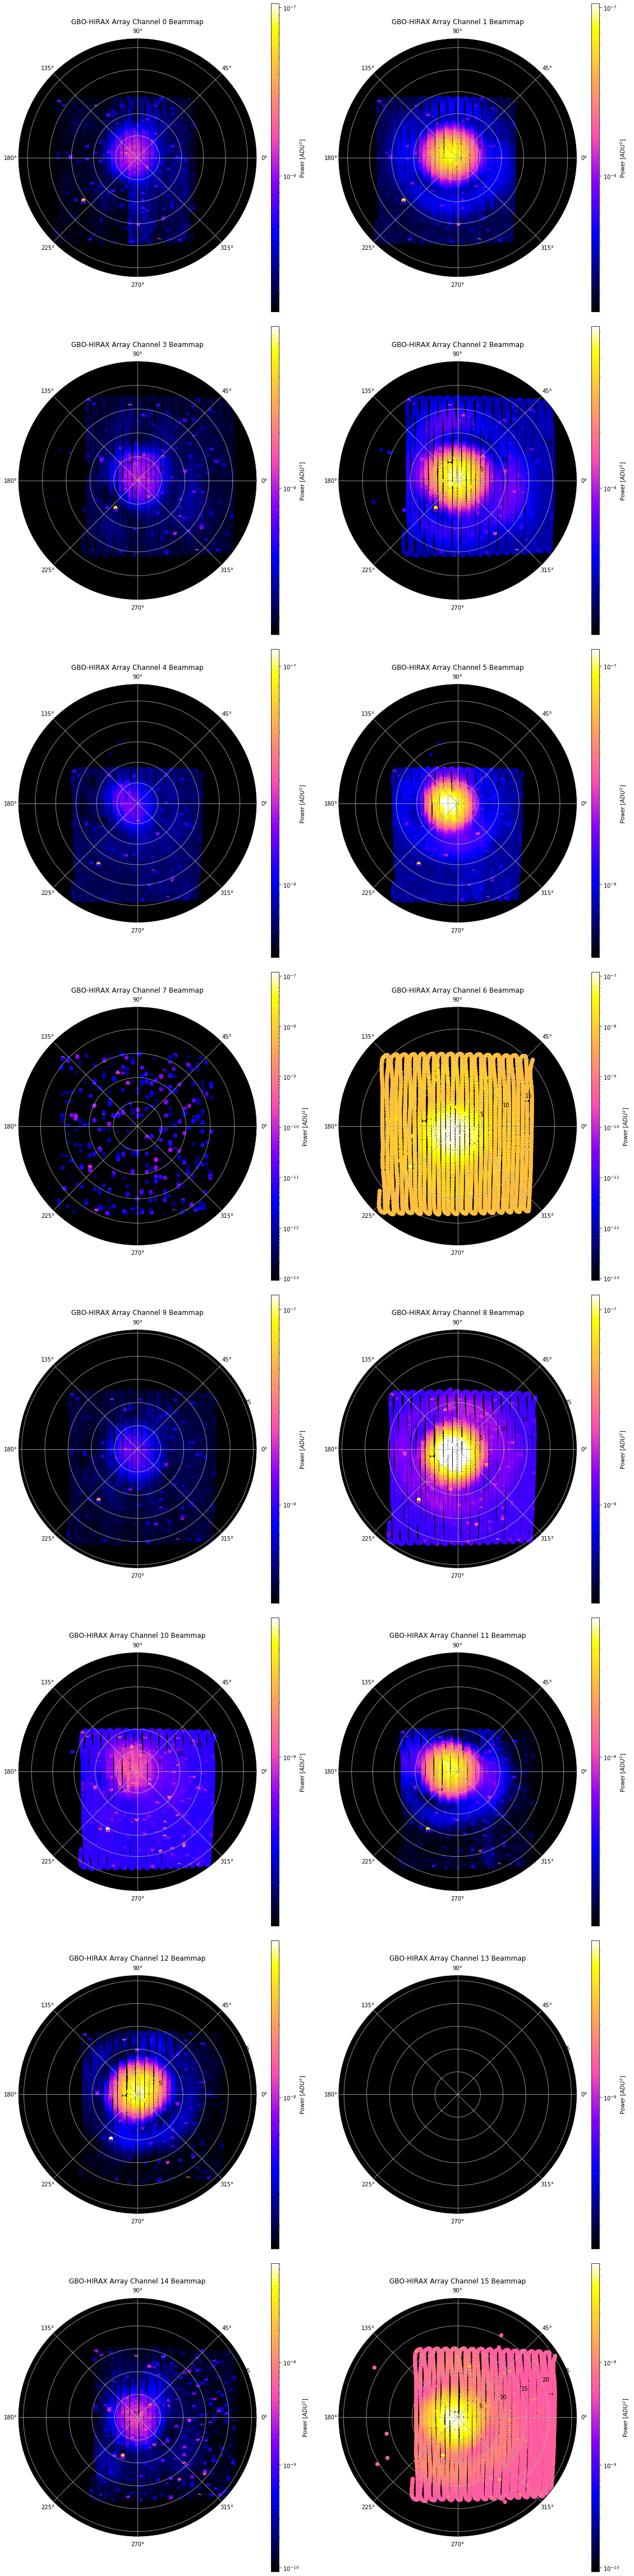

In [70]:
mainbeamconcat.Plot_Beammap_LC(t_bounds=[4125,24000],\
                                 f_bounds=[900,910],\
                                 coord_args="Pol", #"LC","Pol"\
                                 pulse_args="on",# None,"on","off","meanspec_on","meanspec_bg","meanspec_meansub"\
                                 cbounds=[],#[1e-11,1e-7], # 1e-11,1e-7 \
                                 dotsize=40)

In [87]:
tlb,tub=[4125,24000] # Full Grid
t_inds=np.intersect1d(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.inds_on)

AFit_f_params=np.zeros((mainbeamconcat.n_channels,len(mainbeamconcat.f_arr),4))
GFit_f_params=np.zeros((mainbeamconcat.n_channels,len(mainbeamconcat.f_arr),5))
for k in range(mainbeamconcat.n_channels):
    print(k)
    for find,freq in enumerate(mainbeamconcat.f_arr):
        mbx=mainbeamconcat.drone_xyz_LC_interp[t_inds,0]
        mby=mainbeamconcat.drone_xyz_LC_interp[t_inds,1]
        mbz=mainbeamconcat.drone_xyz_LC_interp[t_inds,2]
        mbV=mainbeamconcat.V_meansub[t_inds,find,k]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        x00=Array_Coords[int(k/2),0]
        y00=Array_Coords[int(k/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        pA=np.array([amp0,x00,y00,rad0])
        BA=(np.array([0.0,-50.0,-50.0,0.0]),np.array([1e-6,50,50,50]))
        pG=np.array([amp0,x00,xsig0,y00,ysig0])
        BG=(np.array([0.0,-30.0,0.0,-30.0,0.0]),np.array([1e-6,30,50,30,50]))
        AFit_f_params[k,find,:]=least_squares(Airy_2d_LC_opt,x0=pA,args=mb_input_data).x
        GFit_f_params[k,find,:]=least_squares(Gauss_2d_LC_opt,x0=pG,args=mb_input_data).x

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [96]:
tlb,tub=[4125,24000] # Full Grid
t_inds=np.intersect1d(mainbeamconcat.t_index[tlb:tub],mainbeamconcat.inds_off)

AFit_f_params_off=np.zeros((mainbeamconcat.n_channels,len(mainbeamconcat.f_arr),4))
GFit_f_params_off=np.zeros((mainbeamconcat.n_channels,len(mainbeamconcat.f_arr),5))
for k in range(mainbeamconcat.n_channels):
    print(k)
    for find,freq in enumerate(mainbeamconcat.f_arr):
        mbx=mainbeamconcat.drone_xyz_LC_interp[t_inds,0]
        mby=mainbeamconcat.drone_xyz_LC_interp[t_inds,1]
        mbz=mainbeamconcat.drone_xyz_LC_interp[t_inds,2]
        mbV=mainbeamconcat.V[t_inds,find,k]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        x00=Array_Coords[int(k/2),0]
        y00=Array_Coords[int(k/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        pA=np.array([amp0,x00,y00,rad0])
        BA=(np.array([0.0,-50.0,-50.0,0.0]),np.array([1e-6,50,50,50]))
        pG=np.array([amp0,x00,xsig0,y00,ysig0])
        BG=(np.array([0.0,-30.0,0.0,-30.0,0.0]),np.array([1e-6,30,50,30,50]))
        AFit_f_params_off[k,find,:]=least_squares(Airy_2d_LC_opt,x0=pA,args=mb_input_data).x
        GFit_f_params_off[k,find,:]=least_squares(Gauss_2d_LC_opt,x0=pG,args=mb_input_data).x

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [10]:
## Thursday 100m RFI Grid Flight w/ 2 Channels / 1 Dishes:

## Initialize correlator data class and pull auto correlations:
gaindir='/hirax/GBO_Data/TONE_ACQ/digital_gains/20210826T162023Z_yale_drone_yale_digitalgain/'
datadir='/hirax/GBO_Data/Emilys_Rsync/processed/20210826T162023Z_yale_drone/corr/20210826T162036Z/'

rfi_corr=Corr_Data(n_channels=16,\
                   chmap=GBO8_chmap,\
                   Data_Directory=datadir,\
                   Working_Directory=workingdir,\
                   #Data_File_Index=None,\
                   Gain_Directory=gaindir)

Initializing Correlator Class using:
 --> /hirax/GBO_Data/Emilys_Rsync/processed/20210826T162023Z_yale_drone/corr/20210826T162036Z/
 --> Arrays initialized with shape (144, 256, 1023, 2)
Assigning array values by reading in data files:
 --> Loading File: 0143_processed/0143_processed

In [11]:
## Read Drone Data: 
drone_directory='/hirax/all_drone_data/datcon_csv/'
ndishes=8
rfi_drone=Drone_Data(dronedir=drone_directory,\
                                FLYTAG='FLY526.csv',\
                                Origin_llh=GBO_HIRAX_DISH_0,\
                                Origin_key='Hirax_Dish_0',\
                                dkeys=Array_Keys[:ndishes],\
                                dcoords=Array_Coords[:ndishes],\
                                dpointings=Array_Pointings[:ndishes],\
                                dpols=Array_Pols[:ndishes])

Initializing drone data via datcon_csv routine: FLY526.csv
Interpolating time starting at 2021-08-26T16:24:44Z
generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
generating dish and receiver line of sight coordinates.


In [15]:
rfi_concat=CONCAT(CORRDATCLASS=rfi_corr,DRONEDATCLASS=rfi_drone)

Initializing CONCAT CLASS using:
 --> /hirax/GBO_Data/Emilys_Rsync/processed/20210826T162023Z_yale_drone/corr/20210826T162036Z/
 --> FLY526.csv


/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 30951 elements
  --> drone timestamp axis contains 12230 elements


/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


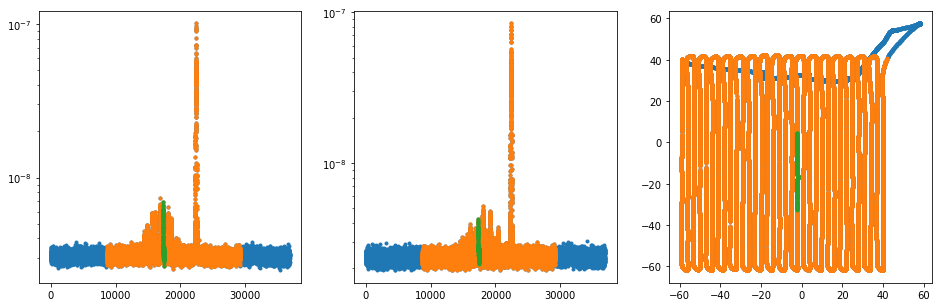

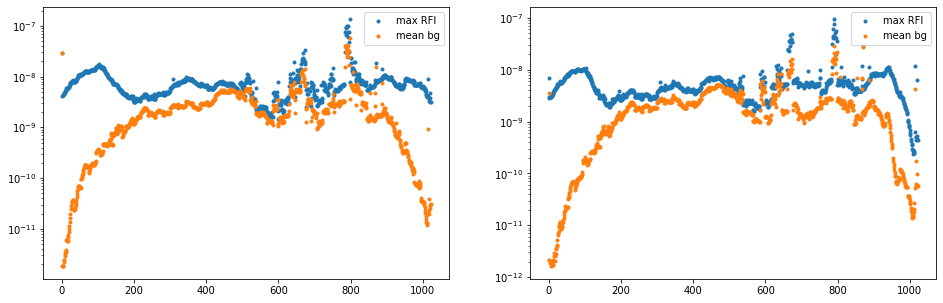

In [65]:
fig1,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
tlb,tub=[0,-1]
ax1.semilogy(rfi_concat.t_index[tlb:tub],rfi_concat.V[tlb:tub,400,0],'.')
ax2.semilogy(rfi_concat.t_index[tlb:tub],rfi_concat.V[tlb:tub,400,1],'.')
ax3.plot(rfi_concat.drone_xyz_LC_interp[tlb:tub,0],rfi_concat.drone_xyz_LC_interp[tlb:tub,1],'.')
tlb,tub=[8700,29200]
ax1.semilogy(rfi_concat.t_index[tlb:tub],rfi_concat.V[tlb:tub,400,0],'.')
ax2.semilogy(rfi_concat.t_index[tlb:tub],rfi_concat.V[tlb:tub,400,1],'.')
ax3.plot(rfi_concat.drone_xyz_LC_interp[tlb:tub,0],rfi_concat.drone_xyz_LC_interp[tlb:tub,1],'.')
tlb,tub=[17300,17500]
ax1.semilogy(rfi_concat.t_index[tlb:tub],rfi_concat.V[tlb:tub,400,0],'.')
ax2.semilogy(rfi_concat.t_index[tlb:tub],rfi_concat.V[tlb:tub,400,1],'.')
ax3.plot(rfi_concat.drone_xyz_LC_interp[tlb:tub,0],rfi_concat.drone_xyz_LC_interp[tlb:tub,1],'.')

fig2,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,5))
for i,ax in enumerate([ax1,ax2]):
    ax.semilogy(np.nanmax(rfi_concat.V[17300:17500,:,i],axis=0),'.',label='max RFI')
    ax.semilogy(np.nanmean(rfi_concat.V[0:2000,:,i],axis=0),'.',label='mean bg')
    ax.legend()


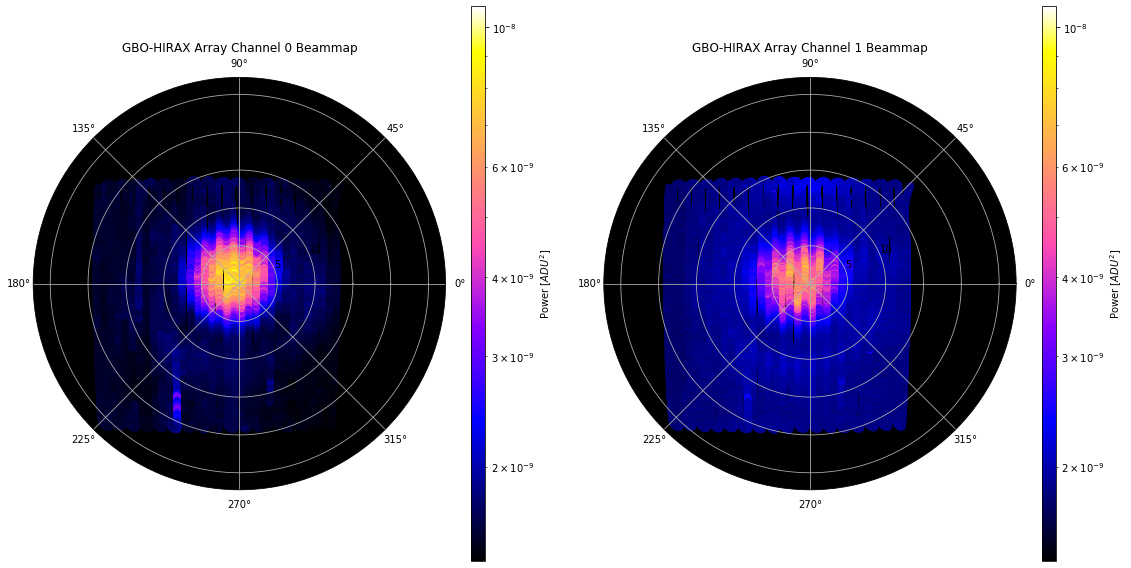

In [71]:
rfi_concat.Plot_Beammap_LC(t_bounds=[8700,29200],\
                           f_bounds=[900,910],\
                           coord_args="Pol", #"LC","Pol"\
                           pulse_args=None,# None,"on","off","meanspec_on","meanspec_bg","meanspec_meansub"\
                           cbounds=[],#[1e-11,1e-7], # 1e-11,1e-7 \
                           dotsize=40)

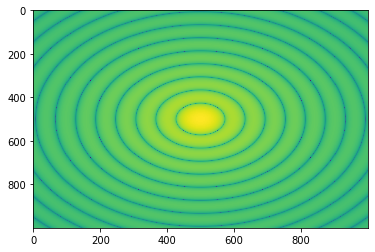

In [78]:
def Airy_2d_LC_opt(P,x,y,V):
    amp,x0,y0,rad=P
    return AD.evaluate(x,y,amp,x0,y0,rad)-V

def Gauss_2d_LC_opt(P,x,y,V):
    amp,x0,xsig,y0,ysig=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))-V

def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))

from astropy.modeling.models import AiryDisk2D

AD=AiryDisk2D(1,5,5,radius=1)
x=np.linspace(-60,60,1000)
y=np.linspace(-60,60,1000)
dat=np.zeros((len(x),len(y)))
for i,val in enumerate(x):
    dat[i]=AD.evaluate(val,y,10,0,0,radius=8.75)
    
imshow(dat,aspect="auto",norm=LogNorm())

In [80]:
tlb,tub=[8700,29200] # Full Grid
t_inds=rfi_concat.t_index[tlb:tub]

rfi_AFit_f_params=np.zeros((rfi_concat.n_channels,len(rfi_concat.f_arr),4))
rfi_GFit_f_params=np.zeros((rfi_concat.n_channels,len(rfi_concat.f_arr),5))
for k in range(rfi_concat.n_channels):
    print(k)
    for find,freq in enumerate(rfi_concat.f_arr):
        mbx=rfi_concat.drone_xyz_LC_interp[t_inds,0]
        mby=rfi_concat.drone_xyz_LC_interp[t_inds,1]
        mbz=rfi_concat.drone_xyz_LC_interp[t_inds,2]
        mbV=rfi_concat.V[t_inds,find,k]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        x00=Array_Coords[int(k/2),0]
        y00=Array_Coords[int(k/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        pA=np.array([amp0,x00,y00,rad0])
        BA=(np.array([0.0,-50.0,-50.0,0.0]),np.array([1e-6,50,50,50]))
        pG=np.array([amp0,x00,xsig0,y00,ysig0])
        BG=(np.array([0.0,-30.0,0.0,-30.0,0.0]),np.array([1e-6,30,50,30,50]))
        rfi_AFit_f_params[k,find,:]=least_squares(Airy_2d_LC_opt,x0=pA,args=mb_input_data).x
        rfi_GFit_f_params[k,find,:]=least_squares(Gauss_2d_LC_opt,x0=pG,args=mb_input_data).x

0
1


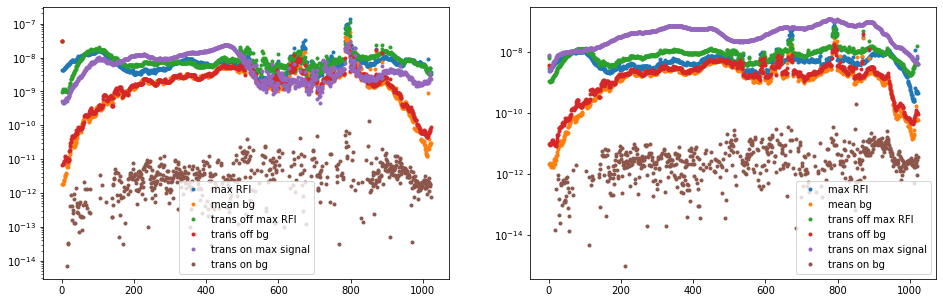

In [ ]:
fig1,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,5))
for i,ax in enumerate([ax1,ax2]):
    ax.semilogy(np.nanmax(rfi_concat.V[17300:17500,:,i],axis=0),'.',label='max RFI')
    ax.semilogy(np.nanmean(rfi_concat.V[0:2000,:,i],axis=0),'.',label='mean bg')
    
    ax.semilogy(np.nanmax(mainbeamconcat.V_bg_construct[13100:13650,:,i],axis=0),'.',label='trans off max RFI')
    ax.semilogy(np.nanmean(mainbeamconcat.V_bg_construct[0:2000,:,i],axis=0),'.',label='trans off bg')
    ax.semilogy(np.nanmax(mainbeamconcat.V_meansub[13100:13650,:,i],axis=0),'.',label='trans on max signal')
    ax.semilogy(np.nanmean(mainbeamconcat.V_meansub[0:2000,:,i],axis=0),'.',label='trans on bg')
    ax.legend()
    
fig2,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,5))
for i,ax in enumerate([ax1,ax2]):
    ax.semilogy(AFit_f_params[i,:,0],'.',label='transmitter on')
    ax.semilogy(AFit_f_params_off[i,:,0],'.',label='transmitter off')
    ax.semilogy(rfi_AFit_f_params[i,:,0],'.',label='RFI flight')
    ax.legend()